In [1]:
import sys
import math
import torch
import numpy as np
import matplotlib.pyplot as plt

from sklearn.mixture import GaussianMixture

In [2]:
sys.path.append('../')

In [3]:
from pydil.optimal_transport import OptimalTransportSolver
from pydil.optimal_transport import GaussianMixtureBarycenterSolver
from pydil.optimal_transport import JointMixtureWassersteinDistance

from pydil.gmm_dictionary import DiagonalGaussianMixture
from pydil.gmm_dictionary import DiagonalLabeledGaussianMixture
from pydil.gmm_dictionary import LabeledGaussianMixtureDictionary

from pydil.utils import visualize_gmm

2024-08-02 17:09:59.092647: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-02 17:09:59.093926: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-02 17:09:59.117343: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-02 17:09:59.496755: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
def make_classification_dataset(mean,
                                cov,
                                v=None,
                                separation=1,
                                n=200):
    x1 = np.random.multivariate_normal(mean, cov, size=n)
    if v is None:
        v = np.random.randn(2,)
        v = separation * (v / np.linalg.norm(v)).reshape(1, -1)
    elif np.linalg.norm(v) != separation:
        v = separation * (v / np.linalg.norm(v)).reshape(1, -1)
    else:
        v = v.reshape(1, -1)
    x2 = x1 + v
    X = np.concatenate([x1, x2], axis=0)
    y = np.array([0] * len(x1) + [1] * len(x2))

    return X, y

In [5]:
def msda_toy_example(n_datasets,
                     n_samples=400,
                     angle_min=0.0,
                     angle_max=45,
                     separation=6):
    mu = np.array([0, 0])
    angles = np.linspace(angle_min, angle_max, n_datasets)
    Xs, Ys = [], []
    for i in range(n_datasets - 1):
        A = np.random.randn(2, 2)
        cov = .25 * np.dot(A.T, A) + np.eye(2)
        v = np.array([np.cos((np.pi / 180) * angles[i]),
                      np.sin((np.pi / 180) * angles[i])])
        X, y = make_classification_dataset(mu, cov, v=v,
                                           separation=separation,
                                           n=n_samples)

        Xs.append(torch.from_numpy(X).float())
        Ys.append(
            torch.nn.functional.one_hot(torch.from_numpy(y).long(),
                                        num_classes=2).float())

    A = np.random.randn(2, 2)
    cov = .1 * np.dot(A.T, A) + np.eye(2)
    v = np.array([np.cos((np.pi / 180) * angles[-1]),
                  np.sin((np.pi / 180) * angles[-1])])
    Xt, yt = make_classification_dataset(mu, cov,
                                         v=v,
                                         separation=separation,
                                         n=n_samples)
    Xt = torch.from_numpy(Xt).float()
    Yt = torch.nn.functional.one_hot(
        torch.from_numpy(yt).long(), num_classes=2).float()

    return Xs, Ys, Xt, Yt

In [6]:
Xs, Ys, Xt, Yt = msda_toy_example(
    n_datasets=4,
    n_samples=500,
    angle_min=0,
    angle_max=30,
    separation=10)

In [7]:
true_features = Xs + [Xt,]
true_labels = Ys + [Yt,]

In [8]:
xmin, xmax = torch.cat(true_features, dim=0)[:, 0].min(), torch.cat(true_features, dim=0)[:, 0].max()
ymin, ymax = torch.cat(true_features, dim=0)[:, 1].min(), torch.cat(true_features, dim=0)[:, 1].max()
print(xmin, xmax, ymin, ymax)

tensor(-5.3704) tensor(16.5664) tensor(-4.6491) tensor(7.8948)


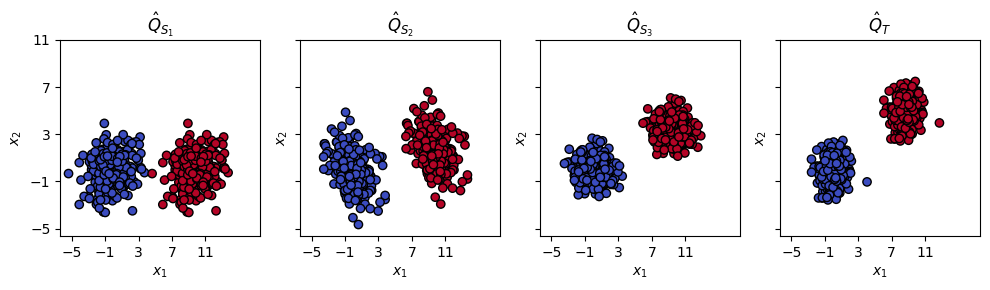

In [9]:
fig, axes = plt.subplots(1, 4, figsize=(10, 3), sharex=True, sharey=True)

for i, (Xi, Yi, ax) in enumerate(zip(true_features[:-1], true_labels[:-1], axes.flatten()[:-1])):
    ax.scatter(x=Xi[::2, 0], y=Xi[::2, 1], c=Yi[::2, 1], cmap='coolwarm', edgecolor='k')
    ax.set_title(r"$\hat{Q}_{S_{" + str(i + 1) + r"}}$")

    ax.set_xlim([xmin - 1, xmax + 1])
    ax.set_ylim([ymin - 1, ymax + 1])

    ax.set_xticks([-5, -1, 3, 7, 11])
    ax.set_yticks([-5, -1, 3, 7, 11])

    ax.set_xlabel(r'$x_{1}$')
    ax.set_ylabel(r'$x_{2}$')

ax = axes.flatten()[-1]
Xi = true_features[-1]
Yi = true_labels[-1]
ax.scatter(x=Xi[::2, 0], y=Xi[::2, 1], c=Yi[::2, 1], cmap='coolwarm', edgecolor='k')
ax.set_title(r"$\hat{Q}_{T}$")

ax.set_xlabel(r'$x_{1}$')
ax.set_ylabel(r'$x_{2}$')

plt.tight_layout()

In [10]:
source_gmms = [
    DiagonalLabeledGaussianMixture(
        components_per_class=5,
        random_state=0,
        dtype=torch.float32,
        device='cpu'
    ).fit(Xs_k, Ys_k) for Xs_k, Ys_k in zip(Xs, Ys)
]

In [11]:
target_gmm = DiagonalGaussianMixture(
    n_components=10,
    random_state=0,
    dtype=torch.float32,
    device='cpu'
).fit(Xt)

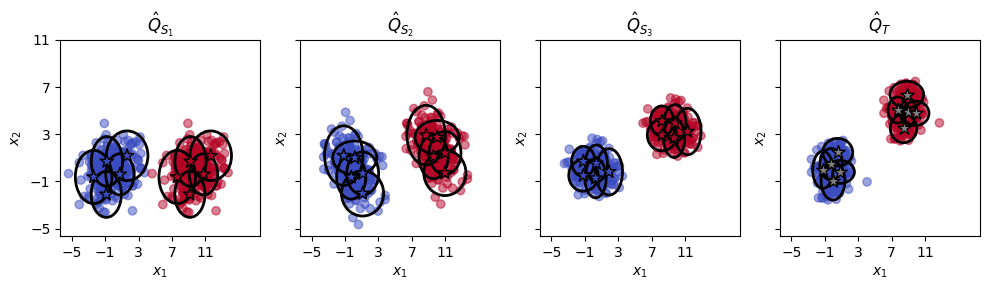

In [12]:
fig, axes = plt.subplots(1, 4, figsize=(10, 3), sharex=True, sharey=True)

for i, (Xi, Yi, ax) in enumerate(zip(true_features[:-1], true_labels[:-1], axes.flatten()[:-1])):
    ax.scatter(x=Xi[::2, 0], y=Xi[::2, 1], c=Yi[::2, 1], cmap='coolwarm', alpha=0.5)
    visualize_gmm(source_gmms[i].means,
                  torch.stack([torch.diag(C) for C in source_gmms[i].variances]),
                  ax=ax,
                  kwargs_scatter={'c': source_gmms[i].labels[:, 1],
                                  'cmap': plt.cm.coolwarm,
                                  'marker': '*',
                                  's': 100,
                                  'edgecolor': 'k',
                                  'zorder': 5},
                  kwargs_ellipse={'facecolor': 'none',
                                  'edgecolor':'k',
                                  'linewidth': 2,
                                  'zorder': 3})
    ax.set_title(r"$\hat{Q}_{S_{" + str(i + 1) + r"}}$")

    ax.set_xlim([xmin - 1, xmax + 1])
    ax.set_ylim([ymin - 1, ymax + 1])

    ax.set_xticks([-5, -1, 3, 7, 11])
    ax.set_yticks([-5, -1, 3, 7, 11])

    ax.set_xlabel(r'$x_{1}$')
    ax.set_ylabel(r'$x_{2}$')

ax = axes.flatten()[-1]
Xi = true_features[-1]
Yi = true_labels[-1]
ax.scatter(x=Xi[::2, 0], y=Xi[::2, 1], c=Yi[::2, 1], cmap='coolwarm', alpha=0.5)
visualize_gmm(target_gmm.means,
              torch.stack([torch.diag(C) for C in target_gmm.variances]),
              ax=ax,
              kwargs_scatter={'c': 'gray',
                              'marker': '*',
                              's': 100,
                              'edgecolor': 'k',
                              'zorder': 5},
              kwargs_ellipse={'facecolor': 'none',
                              'edgecolor':'k',
                              'linewidth': 2,
                              'zorder': 3})
ax.set_title(r"$\hat{Q}_{T}$")

ax.set_xlabel(r'$x_{1}$')
ax.set_ylabel(r'$x_{2}$')

plt.tight_layout()

In [13]:
ot_solver = OptimalTransportSolver()
barycenter_solver = GaussianMixtureBarycenterSolver(
    ot_solver=ot_solver,
    propagate_labels=True,
    penalize_labels=True)
loss_fn = JointMixtureWassersteinDistance(
    ot_solver=ot_solver)

In [14]:
a = torch.ones(5) / 5
b = torch.ones(5) / 5
C = torch.randn(5, 5)
ot_solver(a, b, C)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.2000],
        [0.0000, 0.0000, 0.0000, 0.2000, 0.0000],
        [0.0000, 0.0000, 0.2000, 0.0000, 0.0000],
        [0.2000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.2000, 0.0000, 0.0000, 0.0000]])

In [20]:
gmm_dict = LabeledGaussianMixtureDictionary(
    ot_solver=ot_solver,
    barycenter_solver=barycenter_solver,
    loss_fn=loss_fn,
    n_components=target_gmm.n_components,
    n_atoms=3,
    n_dim=2,
    n_classes=2,
    n_measures=4,
    tensor_dtype=torch.float32,
    device='cpu',
    track_atoms=True,
    track_nll=True
)

In [21]:
gmm_dict.fit(
    gmms=source_gmms + [target_gmm,],
    n_iter_max=200,
    verbose=True,
    validation_data=[(X, Y) for X, Y in zip(true_features, true_labels)]
)

[Domain 0] nll: 21.651103973388672, acc: 0.5
[Domain 1] nll: 20.783803939819336, acc: 0.5
[Domain 2] nll: 20.462806701660156, acc: 0.5
[Domain 3] nll: 21.023365020751953, acc: 0.5
It 0/200, Loss: 419.97918701171875
[Domain 0] nll: 21.955291748046875, acc: 0.74
[Domain 1] nll: 21.93158531188965, acc: 0.778
[Domain 2] nll: 20.660463333129883, acc: 0.764
[Domain 3] nll: 20.766597747802734, acc: 0.795
It 1/200, Loss: 370.9984436035156
[Domain 0] nll: 22.44171714782715, acc: 0.762
[Domain 1] nll: 20.94817543029785, acc: 0.792
[Domain 2] nll: 21.07842254638672, acc: 0.772
[Domain 3] nll: 19.312328338623047, acc: 0.8
It 2/200, Loss: 322.64263916015625
[Domain 0] nll: 22.165943145751953, acc: 0.781
[Domain 1] nll: 20.986736297607422, acc: 0.794
[Domain 2] nll: 21.14101219177246, acc: 0.784
[Domain 3] nll: 19.39964485168457, acc: 0.812
It 3/200, Loss: 283.05133056640625
[Domain 0] nll: 21.73883056640625, acc: 0.794
[Domain 1] nll: 20.066131591796875, acc: 0.807
[Domain 2] nll: 18.42511749267578

[Domain 3] nll: 7.294578552246094, acc: 0.998
It 43/200, Loss: 54.18759536743164
[Domain 0] nll: 10.435749053955078, acc: 0.968
[Domain 1] nll: 9.60622787475586, acc: 0.991
[Domain 2] nll: 7.826465129852295, acc: 0.994
[Domain 3] nll: 7.541502952575684, acc: 0.999
It 44/200, Loss: 52.475860595703125
[Domain 0] nll: 11.46250057220459, acc: 0.972
[Domain 1] nll: 9.13851261138916, acc: 0.993
[Domain 2] nll: 7.245709419250488, acc: 0.995
[Domain 3] nll: 7.348189353942871, acc: 0.998
It 45/200, Loss: 50.68370056152344
[Domain 0] nll: 10.682621002197266, acc: 0.971
[Domain 1] nll: 8.940251350402832, acc: 0.992
[Domain 2] nll: 7.47318696975708, acc: 0.997
[Domain 3] nll: 7.029357433319092, acc: 0.998
It 46/200, Loss: 49.34526443481445
[Domain 0] nll: 10.843260765075684, acc: 0.974
[Domain 1] nll: 8.851397514343262, acc: 0.993
[Domain 2] nll: 7.315193176269531, acc: 0.998
[Domain 3] nll: 6.967832565307617, acc: 0.999
It 47/200, Loss: 47.685054779052734
[Domain 0] nll: 10.37984561920166, acc: 0

It 91/200, Loss: 9.329768180847168
[Domain 0] nll: 5.153511047363281, acc: 0.998
[Domain 1] nll: 4.99796724319458, acc: 1.0
[Domain 2] nll: 4.279787540435791, acc: 1.0
[Domain 3] nll: 3.848677158355713, acc: 1.0
It 92/200, Loss: 9.015754699707031
[Domain 0] nll: 5.124511241912842, acc: 0.998
[Domain 1] nll: 4.952486515045166, acc: 1.0
[Domain 2] nll: 4.252678394317627, acc: 1.0
[Domain 3] nll: 3.85496187210083, acc: 1.0
It 93/200, Loss: 8.667658805847168
[Domain 0] nll: 5.097894668579102, acc: 0.999
[Domain 1] nll: 4.936209678649902, acc: 1.0
[Domain 2] nll: 4.225583076477051, acc: 1.0
[Domain 3] nll: 3.798698663711548, acc: 1.0
It 94/200, Loss: 8.527029991149902
[Domain 0] nll: 5.067765712738037, acc: 0.999
[Domain 1] nll: 4.917298316955566, acc: 1.0
[Domain 2] nll: 4.256033420562744, acc: 1.0
[Domain 3] nll: 3.754767656326294, acc: 1.0
It 95/200, Loss: 7.852222919464111
[Domain 0] nll: 5.0408711433410645, acc: 0.999
[Domain 1] nll: 4.893668174743652, acc: 1.0
[Domain 2] nll: 4.172045

[Domain 2] nll: 3.823679208755493, acc: 1.0
[Domain 3] nll: 3.6050665378570557, acc: 1.0
It 140/200, Loss: 2.728303909301758
[Domain 0] nll: 4.467702865600586, acc: 0.998
[Domain 1] nll: 4.328878402709961, acc: 1.0
[Domain 2] nll: 3.8197829723358154, acc: 1.0
[Domain 3] nll: 3.6023106575012207, acc: 1.0
It 141/200, Loss: 2.9310030937194824
[Domain 0] nll: 4.464731216430664, acc: 0.998
[Domain 1] nll: 4.32498025894165, acc: 1.0
[Domain 2] nll: 3.84576678276062, acc: 1.0
[Domain 3] nll: 3.5888121128082275, acc: 1.0
It 142/200, Loss: 3.246727705001831
[Domain 0] nll: 4.461657524108887, acc: 0.998
[Domain 1] nll: 4.342775344848633, acc: 1.0
[Domain 2] nll: 3.8158788681030273, acc: 1.0
[Domain 3] nll: 3.5887584686279297, acc: 1.0
It 143/200, Loss: 2.8431806564331055
[Domain 0] nll: 4.4583306312561035, acc: 0.998
[Domain 1] nll: 4.325606346130371, acc: 1.0
[Domain 2] nll: 3.8011507987976074, acc: 1.0
[Domain 3] nll: 3.585481882095337, acc: 1.0
It 144/200, Loss: 2.598017930984497
[Domain 0] n

[Domain 0] nll: 4.426443576812744, acc: 0.998
[Domain 1] nll: 4.291415214538574, acc: 1.0
[Domain 2] nll: 3.8005948066711426, acc: 1.0
[Domain 3] nll: 3.612663507461548, acc: 1.0
It 188/200, Loss: 2.2617363929748535
[Domain 0] nll: 4.426414966583252, acc: 0.998
[Domain 1] nll: 4.280228137969971, acc: 1.0
[Domain 2] nll: 3.8171870708465576, acc: 1.0
[Domain 3] nll: 3.607135057449341, acc: 1.0
It 189/200, Loss: 2.4862563610076904
[Domain 0] nll: 4.426387786865234, acc: 0.998
[Domain 1] nll: 4.2913947105407715, acc: 1.0
[Domain 2] nll: 3.8142917156219482, acc: 1.0
[Domain 3] nll: 3.6195318698883057, acc: 1.0
It 190/200, Loss: 2.675053596496582
[Domain 0] nll: 4.426358699798584, acc: 0.998
[Domain 1] nll: 4.291382789611816, acc: 1.0
[Domain 2] nll: 3.806852102279663, acc: 1.0
[Domain 3] nll: 3.613995313644409, acc: 1.0
It 191/200, Loss: 2.3187625408172607
[Domain 0] nll: 4.426330089569092, acc: 0.998
[Domain 1] nll: 4.291370868682861, acc: 1.0
[Domain 2] nll: 3.831444025039673, acc: 1.0
[D

In [23]:
history = gmm_dict.history

In [24]:
whist = torch.stack(history['weights'])
print(whist.shape)

torch.Size([200, 4, 3])


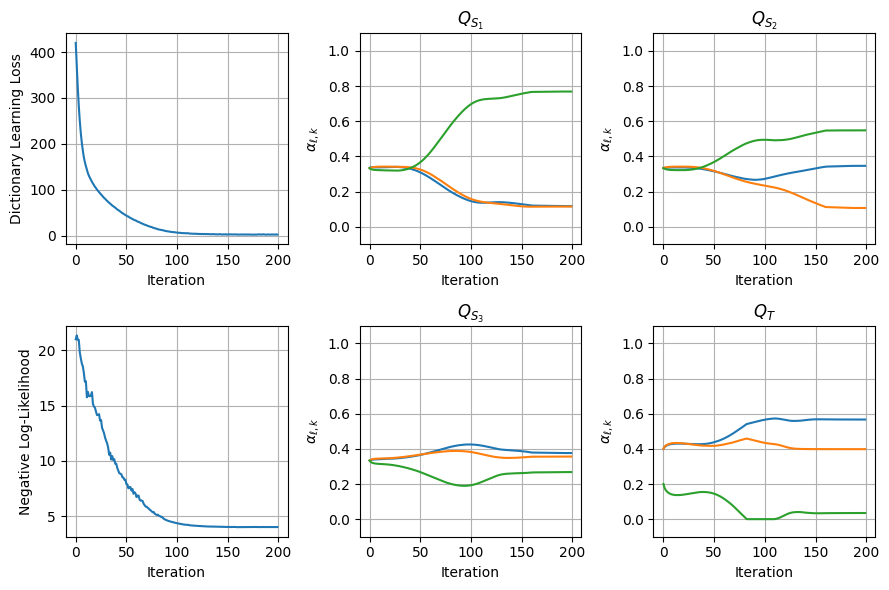

In [26]:
fig, axes = plt.subplots(2, 3, figsize=(9, 6))

axes[0, 0].plot(history['loss'])
axes[0, 0].set_ylabel('Dictionary Learning Loss')
axes[0, 0].set_xlabel('Iteration')
axes[0, 0].set_xticks([0, 50, 100, 150, 200])
axes[0, 0].grid(':')

axes[1, 0].plot(history['nll'])
axes[1, 0].set_ylabel('Negative Log-Likelihood')
axes[1, 0].set_xlabel('Iteration')
axes[1, 0].set_xticks([0, 50, 100, 150, 200])
axes[1, 0].grid(':')

positions = [(0, 1), (0, 2), (1, 1), (1, 2)]
for i in range(3):
    ax = axes[positions[i]]
    for k in range(3):
        ax.plot(whist[:, i, k], label='Atom {}'.format(k + 1))
    ax.set_title(r"$Q_{S_{" + str(i + 1) + "}}$")
    ax.set_ylim([-0.1, 1.1])
    ax.set_ylabel(r'$\alpha_{\ell,k}$')
    ax.set_xlabel('Iteration')
    ax.set_xticks([0, 50, 100, 150, 200])
    ax.grid(':')
ax = axes[positions[3]]
for k in range(3):
    ax.plot(whist[:, 3, k], label='Atom {}'.format(k + 1))
ax.set_ylim([-0.1, 1.1])
ax.set_title(r"$Q_{T}$")
ax.set_ylabel(r'$\alpha_{\ell,k}$')
ax.set_xlabel('Iteration')
ax.set_xticks([0, 50, 100, 150, 200])
ax.grid(':')
plt.tight_layout()

In [29]:
gmms = source_gmms + [target_gmm,]

In [42]:
atoms_means = torch.stack([m.detach() for m in gmm_dict.atoms_means])
atoms_variances = torch.stack([v.detach() for v in gmm_dict.atoms_variances])
atoms_labels = torch.stack([y.detach() for y in gmm_dict.atoms_labels])
barycentric_coordinates = gmm_dict.barycentric_coordinates.detach()

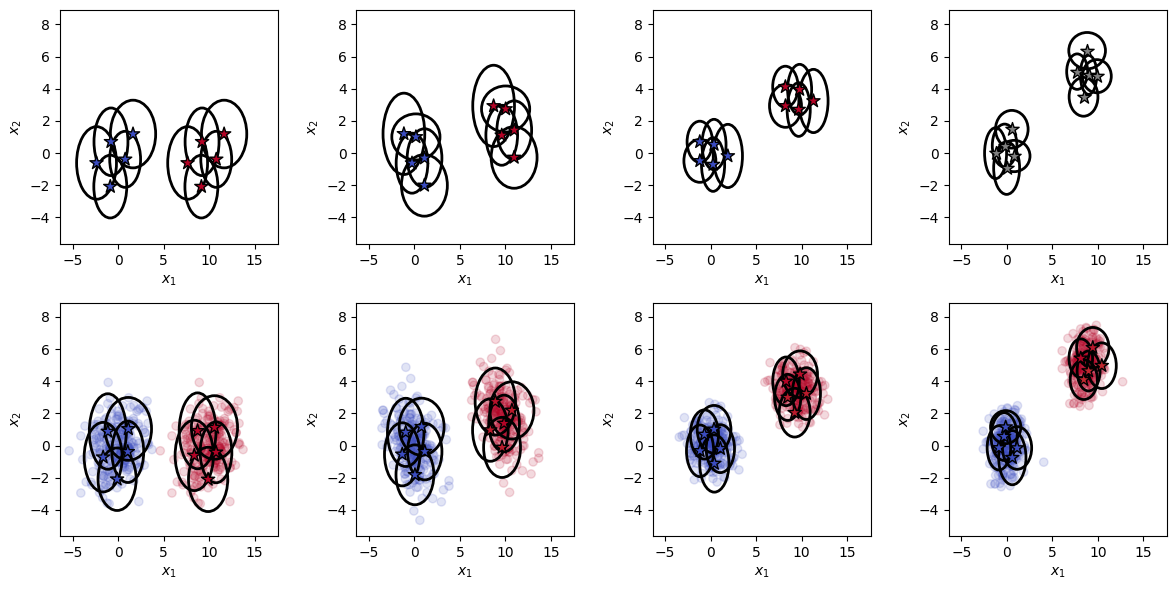

In [44]:
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

for l in range(4):
    ax = axes[0, l]
    # weights, means, variances, labels = gmms[l]
    if gmms[l].labels is not None:
        visualize_gmm(gmms[l].means,
                      torch.stack([torch.diag(C) for C in gmms[l].variances]),
                      ax=ax,
                      kwargs_scatter={'c': gmms[l].labels[:, 1],
                                      'cmap': plt.cm.coolwarm,
                                      'marker': '*',
                                      's': 100,
                                      'edgecolor': 'k',
                                      'zorder': 5},
                      kwargs_ellipse={'facecolor': 'none',
                                      'edgecolor':'k',
                                      'linewidth': 2,
                                      'zorder': 3})
    else:
        visualize_gmm(gmms[l].means,
                      torch.stack([torch.diag(C) for C in gmms[l].variances]),
                      ax=ax,
                      kwargs_scatter={'c': 'gray',
                                      'marker': '*',
                                      's': 100,
                                      'edgecolor': 'k',
                                      'zorder': 5},
                      kwargs_ellipse={'facecolor': 'none',
                                      'edgecolor':'k',
                                      'linewidth': 2,
                                      'zorder': 3})

    ax.set_xlim([xmin - 1, xmax + 1])
    ax.set_ylim([ymin - 1, ymax + 1])

    ax.set_xlabel(r'$x_{1}$')
    ax.set_ylabel(r'$x_{2}$')

    with torch.no_grad():
        barycenter_means, barycenter_variances, barycenter_labels = barycenter_solver(
            atoms_means,
            atoms_variances,
            atoms_labels.softmax(dim=1),
            weights=barycentric_coordinates[l, :]
        )

    ax = axes[1, l]
    ax.scatter(x=true_features[l][::2, 0],
               y=true_features[l][::2, 1],
               c=true_labels[l][::2, 1],
               cmap='coolwarm',
               alpha=0.15, zorder=1)

    visualize_gmm(barycenter_means,
                  torch.stack([torch.diag(C) for C in barycenter_variances]),
                  ax=ax,
                  kwargs_scatter={'c': barycenter_labels[:, 1],
                                  'cmap': plt.cm.coolwarm,
                                  'marker': '*',
                                  's': 100,
                                  'edgecolor': 'k',
                                  'zorder': 5},
                  kwargs_ellipse={'facecolor': 'none',
                                  'edgecolor':'k',
                                  'linewidth': 2,
                                  'zorder': 3})

    
    ax.set_xlim([xmin - 1, xmax + 1])
    ax.set_ylim([ymin - 1, ymax + 1])

    ax.set_xlabel(r'$x_{1}$')
    ax.set_ylabel(r'$x_{2}$')

plt.tight_layout()